In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Naive_Bayes:

    def __init__(self) -> None:
        self.X = None
        self.y = None
        self.classes = None


    @staticmethod
    def gaussian(x : np.ndarray | list, mu : float, sigma : float) -> np.ndarray:
        return (np.exp(-(x-mu)**2 / (2 * sigma**2))) / (np.sqrt(2 * np.pi * sigma**2))


    def fit(self, X : pd.DataFrame, y : pd.DataFrame) -> None:
        self.X = X
        self.y = y
        self.classes = np.unique(self.y)
        self.mu = {}
        self.sigma = {}

        for c in self.classes:
            self.mu[c] = np.array(self.X.iloc[self.y[self.y == c].index].mean())
            self.sigma[c] = np.array(self.X.iloc[self.y[self.y == c].index].std())

        self.prior_probas = {}
        for c in self.classes:
            self.prior_probas[c] = len(self.y[self.y == c]) / len(self.X)



    def predict(self, point : np.ndarray | list) -> int:
        posterior_probas, classes = [], []

        for c in self.classes:
            prior_proba = self.prior_probas[c]
            mu = self.mu[c]
            sigma = self.sigma[c]
            posterior_proba = prior_proba + np.sum(np.log(self.gaussian(point, mu, sigma)))
            posterior_probas.append(posterior_proba)
            classes.append(c)

        return classes[np.argmax(posterior_probas)]

Будем строить предсказания по формуле:
$$a(x) = \arg \max_{y \in Y} λ_y P_y p_y(x)$$
$λ_y$ - функция штрафа, идея в том, что мы оцениваем насколько плохо для нас плохо отнеси объект класса $y$ к другому классу \\
$P_y$ - априорные вероятности классов \\
$p_y(x)$ - функция правдоподобия или плотность распделения \\
Так как мы не можем точно узнать значения апрорных вероятностей каждого класса и плотности распределений, посчтиаем приближенные оценки $\hat{P_y} \hat{p_y}(x)$. Как это сделать? \\
С $\hat{P_y}$ все просто - нам достаточно посчитать количество объектов для каждого класса и разделить на число объектов:
$$ \hat{P_y} = \frac{|X_l^y|}{|X_l|}$$
На самом деле оказывается это оценка сходится к верной, то есть если мы возьмем значение $\hat{P_y}$ и усредним по всем возможным выборкам, мы получим точное значение, то есть: $ P_y = E_X\hat{P_y}$ \\
С плотностями все сложнее. В этом методе мы полагаем плотности распределений нормальным, или:
$$ \hat{p_y}(x) = N(x, μ, σ) = \frac{1}{σ\sqrt{(2 π)^n}} e^{-\frac{1}{2} (\frac{x-μ}{σ})^2} $$
Идея в том, что мы наивно полагаем, что признаки независимые случайные величины, так мы можем посчитать:
$$\hat{p_y}_x = p_{y_1}(\xi_1) \times p_{y_2}(\xi_2) \times ... \times p_{y_n}(\xi_n)$$
Идея в том, что теперь для каждой пары (признак, класс) мы можем посчитать плотности распределения. Теперь подставим все в классификатор выше, заменим умножение сложением с помощью логарифмирования и получим:
$$a(x) = \arg \max_{y \in Y} [\ln(λ_y \hat{P_y}) + ∑_{i = 1}^{n} \ln(p_{y_1}(\xi_i))]$$

In [ ]:
def generate(mu : float, sigma : float, size=100) -> np.ndarray:
    return np.array(np.random.normal(mu, sigma, size))


def generate_feature(x : np.ndarray, y : np.ndarray):
    return np.concatenate((x, y))


def generate_sample_data(size = 100, option : bool = False) -> pd.DataFrame:
    x = generate_feature(generate(0.2, 0.05, size=size // 2), generate(0.4, 0.05, size=size // 2))
    y = generate_feature(generate(0.4, 0.05, size=size // 2), generate(0.6, 0.05, size=size // 2))
    labels = np.array([0] * (size // 2) + [1] * (size // 2))
    if option:
        return x, y, labels, pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})
    return pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})


In [ ]:
x, y, labels, data = generate_sample_data(100, option=True)

Сгенерируем точки, которое мы могли бы разделить на классы, причем скорее всего мы бы легко могли разделить их SVM. Покажем их наглядно.

<Axes: xlabel='x', ylabel='y'>

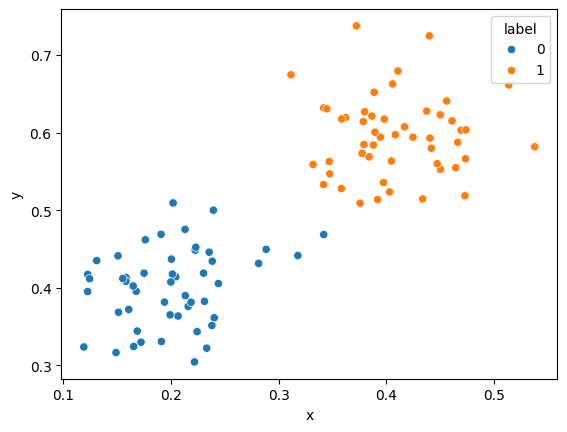

In [ ]:
sns.scatterplot(data=data, x='x', y='y', hue='label')

In [ ]:
model = Naive_Bayes()
model.fit(data[['x', 'y']], data.label)

In [ ]:
n = len(x)
correct = 0
for i in range(n):
    if model.predict([x[i], y[i]]) == labels[i]:
        correct += 1
    else:
        print([x[i], y[i]])
print(correct / n)

[0.341830201924367, 0.4686270609026269]
0.99


Одна точка оказалась классифицирована неправильно, сейчас увидим почему.

In [ ]:
def make_classification_map(best_model : object, x : np.ndarray, y : np.ndarray, data : pd.DataFrame) -> None:

    all_points = []
    for i in np.arange(0, 1, 0.01):
        for j in np.arange(0, 1, 0.01):
          all_points.append([i, j])

    predictions = []
    for i in all_points:
        predictions.append(model.predict(i))


    df = pd.DataFrame(data={'x' : [point[0] for point in all_points], 'y' : [point[1] for point in all_points], 'Label' : predictions})
    sns.scatterplot(data=df, x='x', y='y', hue='Label', palette="magma")
    sns.scatterplot(data=data, x='x', y='y', hue='label')
    plt.show()

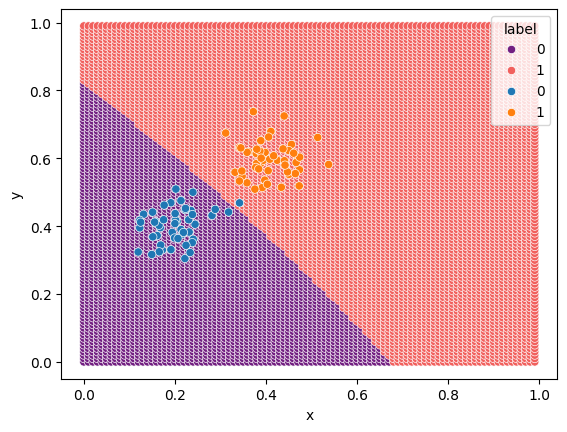

In [ ]:
make_classification_map(model, x, y, data)

Как видно, точка, которая классифицирована неправильно, оказалась по другую сторону разделяющей гиперплоскости.